# **Tutorial: urban monitoring and analysis with remote sensing and spatial information technology - urban heat island and local climate zone mapping**

Instructor: Alberto Vavassori, PhD

Department of Civil and Environmental Engineering

Politecnico di Milano

**Acknowledgment**: This hands-on exercise has been created in the frame of the Space It Up! project, funded by the Italian Space Agency (ASI) and the Italian Ministry of University and Research (MUR) under contract n. 2024-5-E.0 – CUP n. I53D24000060005.

# **0. Introduction**

The workflow is a simplified version of the methodology described in the following publication:

Vavassori, A., Oxoli, D., Venuti, G., Brovelli, M. A., Siciliani de Cumis, M.,
Sacco, P., and Tapete, D. (2024). **A combined Remote Sensing and GIS-based method for Local Climate Zone mapping using PRISMA and Sentinel-2 imagery**, *International Journal of Applied Earth Observation and Geoinformation*, 131, 103944. https://doi.org/10.1016/j.jag.2024.103944

The code involves four main steps:


*   1. Plotting - data exploration and visualisation: plotting the training samples, compute and plot the spectral signatures of LCZs.
*   2. Classification in LCZs: training the RF classification algorithm, classification in LCZs of the study area.
*   3. Accuracy assessment: evaluation of the classification map accuracy on testing samples.
*   4. Comparison with air temperature map: computation of air temperature distribution across the LCZs.





# **1. Plotting - data exploration and visualisation**

## Library installation and import

In [2]:
%load_ext autoreload
%autoreload 

import sys
import os

# Add the module's parent directory to sys.path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lcz_classification import plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import gdown
import rasterio as rio
from rasterio import mask
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import geopandas as gpd
from plotly import graph_objs as go

In [ ]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from rasterio.plot import show
import pandas as pd
import seaborn as sns
from osgeo import gdal, ogr, gdalconst, gdal_array, osr
from scipy.ndimage import median_filter
from shapely.geometry import box
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import plotly.express as px

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

ModuleNotFoundError: No module named 'lcz_classification'

## Data import

In [ ]:
data_dir="../data/"
landsat_file = data_dir + 'satellite_images/L09bands_20230618.tif' # Pre-processed Landsat 9 image:
study_area_file = data_dir + 'study_area/study_area_20230618.gpkg' # Study area (extent of Landsat 9 image):
cmm_file = data_dir + 'study_area/CMM.gpkg' #Metropolitan city of Milan in vector format (geopackage):
training_file = data_dir + 'training_testing/training_set_20230618.gpkg' # Training sample in vector format (geopackage):
training_raster_file = data_dir + 'training_testing/training_set_20230618_30m.tif' #Training samples in raster format:
testing_file = data_dir + 'training_testing/testing_set_20230618.gpkg'
testing_file = data_dir + 'training_testing/testing_set_20230618.gpkg' #Testing samples in vector format (Geopackage):
testing_raster_file = data_dir + 'training_testing/testing_set_20230618_30m.tif' #Testing samples in raster format:
 

Import the **Urban Canopy Parameters (UCPs)** with the original values.

In [ ]:
ucps_path=f"{data_dir}ucps/"
#1) Impervious Surface Fraction:

imperv_file = ucps_path + 'imperviousness_30m_20230618.tif' 

#2) Building Surface Fraction:
perc_build_file = ucps_path + 'percentage_buildings_30m_20230618.tif' 

# 3) Sky View Factor:
svf_file = ucps_path + 'SVF_30m_20230618.tif' 

#4) Tree Canopy Height:
canopy_height_ETH_file =ucps_path +  'canopy_height_ETH_30m_20230618.tif' 

#5) Building Height:
buildings_file =ucps_path +  'building_30m_20230618.tif'  


## Create functions

## Plotting training samples and study area

Definition of the legend: description and color of each LCZ class.

In [ ]:
legend = {
    2: ['Compact mid-rise', '#D10000'],
    3: ['Compact low-rise', '#CD0000'],
    5: ['Open mid-rise', '#FF6600'],
    6: ['Open low-rise', '#FF9955'],
    8: ['Large low-rise', '#BCBCBC'],
    101: ['Dense trees', '#006A00'],
    102: ['Scattered trees', '#00AA00'],
    104: ['Low plants', '#B9DB79'],
    105: ['Bare rock or paved', '#545454'],
    106: ['Bare soil or sand', '#FBF7AF'],
    107: ['Water', '#6A6AFF']
}

Plotting the training sample in an interactive map.

In [ ]:

training, m, shapes = plot_training_samples(training_file, cmm_file, legend)

List of LCZ: ['Compact mid-rise', 'Compact low-rise', 'Open mid-rise', 'Open low-rise', 'Large low-rise', 'Dense trees', 'Scattered trees', 'Low plants', 'Bare rock or paved', 'Bare soil or sand', 'Water']
List of colors: ['#D10000', '#CD0000', '#FF6600', '#FF9955', '#BCBCBC', '#006A00', '#00AA00', '#B9DB79', '#545454', '#FBF7AF', '#6A6AFF']


In [ ]:
m

## Spectral signatures of training samples

Definition of the LCZ classes.

In [ ]:
LCZ_class = list(legend.keys())

Computation of the median spectral signature (and corresponding standard deviation) of the training samples for each LCZ class. Note that B10 (the first stored in the tif file) is removed for the spectral signature computation and plotting.

In [ ]:
# Clip the Landsat image to the polygon extent and compute the spectral signature
band_threshold = 1e-8
spectral_sign = {}
spectral_sign_std = {}
with rio.open(landsat_file) as src:
  for LCZ in LCZ_class:
    print(f'Computed spectral signature in the training samples for class: {legend[LCZ][0]}')
    out_image, out_transform = rio.mask.mask(dataset=src, shapes=shapes[LCZ], crop=True, pad=True)
    out_image[out_image == 0] = np.nan
    out_image = out_image[1:, :, :] # removal of band B10

    spectral_sign[LCZ] = np.nanmedian(out_image, axis=(1, 2))
    spectral_sign_std[LCZ] = np.nanstd(out_image, axis=(1, 2))

    spectral_sign[LCZ] = spectral_sign[LCZ][spectral_sign[LCZ]>band_threshold] # remove values equal to zero
    spectral_sign_std[LCZ] = spectral_sign_std[LCZ][spectral_sign_std[LCZ]>band_threshold] # remove values equal to zero

Computed spectral signature in the training samples for class: Compact mid-rise
Computed spectral signature in the training samples for class: Compact low-rise
Computed spectral signature in the training samples for class: Open mid-rise
Computed spectral signature in the training samples for class: Open low-rise
Computed spectral signature in the training samples for class: Large low-rise
Computed spectral signature in the training samples for class: Dense trees
Computed spectral signature in the training samples for class: Scattered trees
Computed spectral signature in the training samples for class: Low plants
Computed spectral signature in the training samples for class: Bare rock or paved
Computed spectral signature in the training samples for class: Bare soil or sand
Computed spectral signature in the training samples for class: Water


Interactive selection of the LCZ classes for which the median spectral signature is going to be plotted.

In [ ]:
LCZ_names = [value[0] for value in legend.values()]
checkboxes = [widgets.Checkbox(value=True, description=str(LCZ)) for LCZ in LCZ_names]
output = widgets.VBox(children=checkboxes)
output

In [ ]:
selected_LCZ_names = [checkbox.description for checkbox in checkboxes if checkbox.value]
selected_classes = [key for key, value in legend.items() if value[0] in selected_LCZ_names]

Definition of the Landsat 9 central wavelengths (in µm). The first wavelength is removed which corresponds to band B10.

In [ ]:
# Order: B10, B2, B3, B4, B5, B6, B7
wvl = [10.895, 0.482, 0.5615, 0.6545, 0.865, 1.6085, 2.2005]
wvl = wvl[1:] # removal of B10 wavelength

Interactive plot of the median spectral signatures: it is possible to choose which LCZ classes are displayed.

In [ ]:
fig = go.Figure()
for LCZ in sorted(list(legend.keys())):
  fig.add_trace(go.Scatter(x = sorted(wvl),
                            y=spectral_sign[LCZ],
                            name = f"{legend[LCZ][0]}",
                            line_color = legend[LCZ][1]))
  fig.update_xaxes(title_text = "Wavelength (µm)")
  fig.update_yaxes(title_text = "Reflectance")
  fig.update_layout(width = 1000, height = 600, title = 'Median spectral signature of the training samples')

fig.show()

# **2. Classification in LCZs**

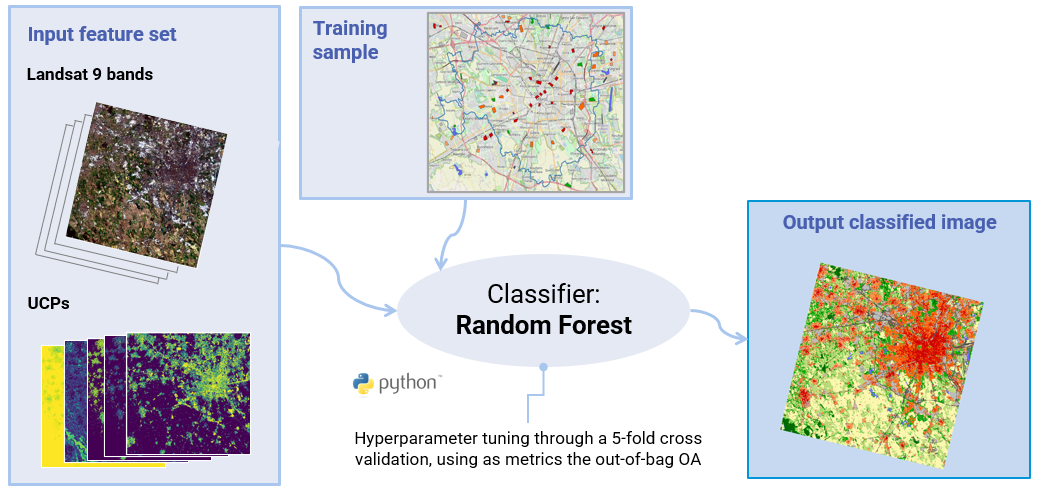

## Area of training samples

Compute and plot the area of each LCZ in the training samples.

In [ ]:
train_data = gpd.read_file(training_file)

# Specify the column to plot
column_names = 'LCZ'

# Calculate the total area for each LCZ class to check if the training samples have balanced area. It is important to keep data balanced for the next classification steps (this is relevant expecially for urban classes, while natural classed usually are more easily classified):
total_area = train_data.groupby(column_names)['geometry'].apply(lambda x: x.area.sum())

# Check the list of LCZ classes available in the provided training set:
train_data['LCZ_name'] = train_data['LCZ'].map(legend).str[0]
classes_LCZ = list(train_data.LCZ_name.unique())
classes_LCZ.sort()
print("List of training samples LCZ classes: ", classes_LCZ)

# Create a dictionary containing the class numbers and the desiderd color to be used for plotting
cmap_colors = [legend[key][1] for key in legend.keys()]
cmap = plt.cm.colors.ListedColormap(cmap_colors, name='LCZ classes colormap')


# Create the bar trace
total_area.index = total_area.index.map(lambda x: legend[x][0])
bar_trace = go.Bar(
    x=total_area.index.astype(str),
    y=total_area,
    marker=dict(color=cmap_colors),
)

# Create the layout
layout = go.Layout(
    title='Area of the training samples',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Total area [m²]', tickformat='1.1e'),
    height = 500,
    width = 600
)

# Create the figure and add the trace
fig = go.Figure(data=[bar_trace], layout=layout)

# Display the figure
fig.show()

List of training samples LCZ classes:  ['Bare rock or paved', 'Bare soil or sand', 'Compact low-rise', 'Compact mid-rise', 'Dense trees', 'Large low-rise', 'Low plants', 'Open low-rise', 'Open mid-rise', 'Scattered trees', 'Water']


## Normalise and plot UCPs

Normalise the values of the UCPs.

In [ ]:
imperv = open_layer(imperv_file)
perc_build = open_layer(perc_build_file)
svf = open_layer(svf_file)
canopy_height = open_layer(canopy_height_ETH_file)
buildings = open_layer(buildings_file)

../data/ucps/imperviousness_30m_20230618.tif shape: (1194, 1223) ---> Max value: 1.00 | Min value: 0.00
../data/ucps/percentage_buildings_30m_20230618.tif shape: (1194, 1223) ---> Max value: 1.00 | Min value: 0.00
../data/ucps/SVF_30m_20230618.tif shape: (1194, 1223) ---> Max value: 1.00 | Min value: 0.30
../data/ucps/canopy_height_ETH_30m_20230618.tif shape: (1194, 1223) ---> Max value: 1.00 | Min value: 0.00
../data/ucps/building_30m_20230618.tif shape: (1194, 1223) ---> Max value: 1.00 | Min value: 0.00


Plot the UCPs.

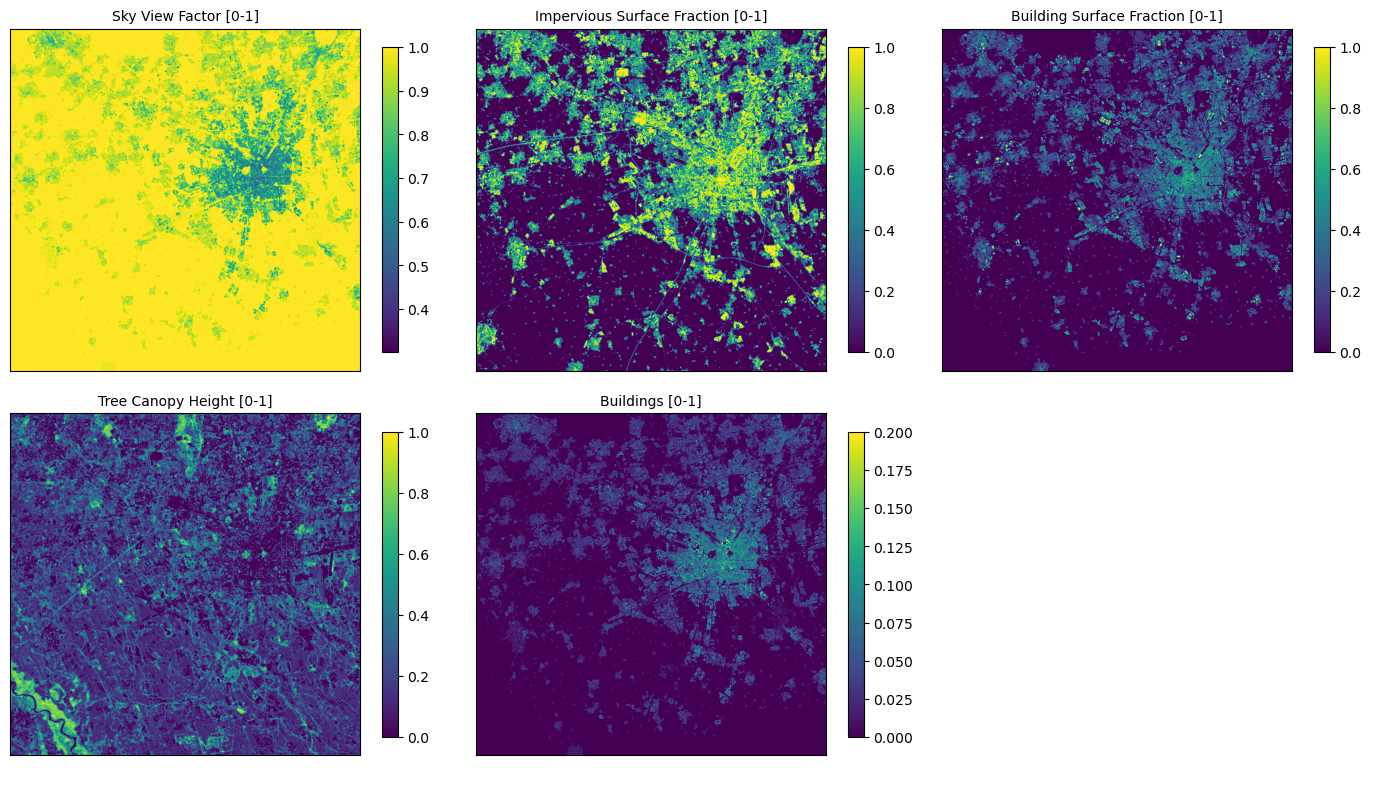

In [ ]:
plot_ucl(imperv, perc_build, svf, canopy_height, buildings)

## Prepare data for training

Open the study area.

In [ ]:
study_area = gpd.read_file(study_area_file)

Create the layer with the Landsat 9 image and the layer with the training sample.

In [ ]:
# Read in our image and training set image
img_ds = gdal.Open(landsat_file, gdal.GA_ReadOnly)
roi_ds = training_raster_file

# Create layers for the image and training samples
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount), gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
  img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

with rio.open(roi_ds) as src:
  # Clip the GeoTIFF using the vector file as a mask
  out_image, out_transform = mask(src, study_area.geometry, crop=True, all_touched=True)
  out_meta = src.meta

with rio.open(training_raster_file) as roi_src:
  roi = roi_src.read().squeeze()

print("Classes in the ROI: ", np.unique(roi))

Classes in the ROI:  [  0   2   3   5   6   8 101 102 104 105 106 107]


Check if the UCP layers and the training sample layer have the same dimension.

In [ ]:
imperv, perc_build, svf, canopy_height, buildings, roi = check_layers_dimension(imperv, perc_build, svf, canopy_height, buildings, roi, img)

Impervious shape:  (1194, 1223, 1)
Build percentage shape:  (1194, 1223, 1)
SVF shape:  (1194, 1223, 1)
Tree Canopy Height shape:  (1194, 1223, 1)
Building shape:  (1194, 1223, 1)
ROI shape:  (1194, 1223)
Landsat image:  (1194, 1223, 7)
(1194, 1223)
0 0
The ROI shape is --> (1194, 1223)


Integrate the UCP layers with the satellite image. This step makes the LCZ mapping method a combined remote sensing and GIS-based approach.

In [ ]:
img = np.dstack((imperv, perc_build, svf, canopy_height, buildings, img))
print(f"The stacked array shape is --> {img.shape}")

The stacked array shape is --> (1194, 1223, 12)


In [ ]:
labels = np.unique(roi[roi > 0])
print(f'The training data include {labels.size} classes: {labels}')

The training data include 11 classes: [  2   3   5   6   8 101 102 104 105 106 107]


In [ ]:
X = img[roi > 0, :]
y = roi[roi > 0]
print(f'X matrix size: {X.shape}')
print(f'y array size: {y.shape}')

X matrix size: (19496, 12)
y array size: (19496,)


## Train-test split and hyperparameter tuning

Split the training into training (80%) and test set (20%).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Tune the Random Forest parameters (number of estimators, maximum features, and criterion).

In [ ]:
best_params, best_score, cv_results = parameter_tuning(X_train, y_train)

Using Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START criterion=gini, max_features=auto, n_estimators=100........
[CV 1/5; 1/12] END criterion=gini, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 1/12] START criterion=gini, max_features=auto, n_estimators=100........
[CV 2/5; 1/12] END criterion=gini, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 1/12] START criterion=gini, max_features=auto, n_estimators=100........
[CV 3/5; 1/12] END criterion=gini, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 1/12] START criterion=gini, max_features=auto, n_estimators=100........
[CV 4/5; 1/12] END criterion=gini, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 1/12] START criterion=gini, max_features=auto, n_estimators=100........
[CV 5/5; 1/12] END criterion=gini, max_features=auto, n_estimators=100;, score=nan total time=   0.0s
[CV 

Best combination of parameters:

In [ ]:
best_params

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}

Corresponding best score (overall accuracy):

In [ ]:
best_score

0.9113235463371725

Train the Random Forest classifier with the above parameter combination.

In [ ]:
clc = RandomForestClassifier(max_features=best_params['max_features'],
                            n_estimators=best_params['n_estimators'],
                            criterion=best_params['criterion'],
                            oob_score=True)

Predict on the testing sample.

In [ ]:
clc.fit(X_train, y_train)
y_pred = clc.predict(X_test)

## Feature importance within the Random Forest classification

In [ ]:
result = permutation_importance(
    clc, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2
)
feature_names = ["Imp", "BSF", "SVF", "CH", "BH", "B02", "B03", "B04", "B05", "B06", "B07", "B10"]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

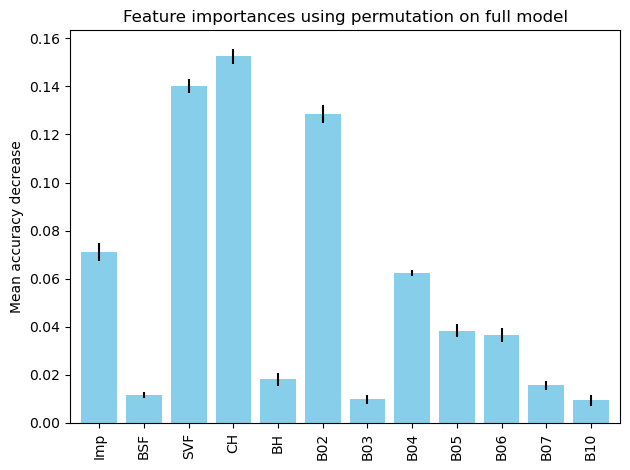

In [ ]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax, color='skyblue', width=0.8)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Compute the accuracy on the validation set (20% of training).

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.903


## Run the classification algorithm

Run the classification of all pixels, apply the median filter (window size 3x3 pixels), and **export the post-processed classification as a GeoTIFF file**.

In [ ]:
file_name = 'classified_RF_20230618_medianfilter_30m.tif'
output_file_path = f'../data/ucps/{file_name}'

In [ ]:
class_prediction, smoothed_image = export_classified_map(img, clc, X, landsat_file)

Reshaped from (1194, 1223, 12) to (1460262, 12)
Folder already exists.
Application of a median filter of size 3...
The smoothed classified file ../data/ucps/classified_RF_20230618_medianfilter_30m.tif has been created!


ModuleNotFoundError: No module named 'google.colab'

## Plot the classified map

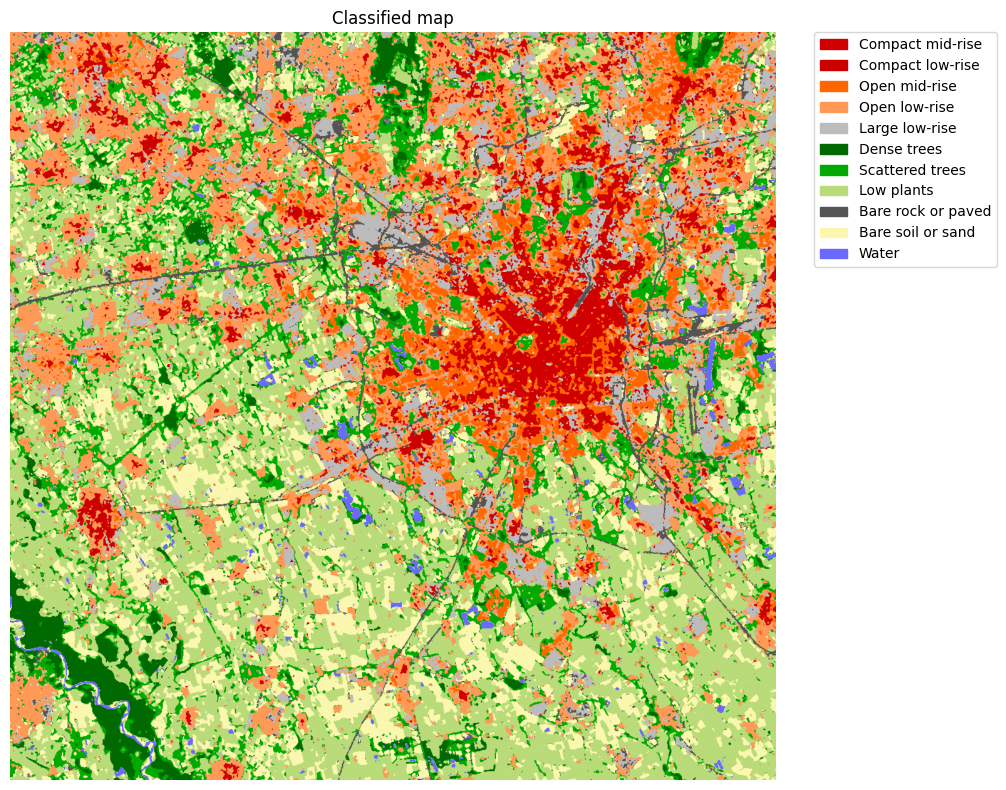

In [ ]:
plot_dynamic_map(smoothed_image, legend)

# **3. Accuracy assessment**

## Import the classified map

In [ ]:
classified_file_id = '1BU4RDWw9xOVQh9O9S3HG4EdWip7TermL'
classified_file = 'classified_RF_20230618_medianfilter_30m.tif'
gdown.download(id=classified_file_id, output=classified_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1BU4RDWw9xOVQh9O9S3HG4EdWip7TermL
To: /content/classified_RF_20230618_medianfilter_30m.tif
100%|██████████| 5.85M/5.85M [00:00<00:00, 53.3MB/s]


'classified_RF_20230618_medianfilter_30m.tif'

## Area of the testing samples

In [ ]:
test_data = gpd.read_file(testing_file)

# Specify the column to plot
column_names = 'LCZ'

# Calculate the total area for each LCZ class to check if the training samples have balanced area. It is important to keep data balanced for the next classification steps (this is relevant expecially for urban classes, while natural classed usually are more easily classified):
total_area = test_data.groupby(column_names)['geometry'].apply(lambda x: x.area.sum())

# Check the list of LCZ classes available in the provided training set:
test_data['LCZ_name'] = test_data['LCZ'].map(legend).str[0]
classes_LCZ = list(test_data.LCZ_name.unique())
classes_LCZ.sort()
print("List of training samples LCZ classes: ", classes_LCZ)

# Create a dictionary containing the class numbers and the desiderd color to be used for plotting
cmap_colors = [legend[key][1] for key in legend.keys()]
cmap = plt.cm.colors.ListedColormap(cmap_colors, name='LCZ classes colormap')


# Create the bar trace
total_area.index = total_area.index.map(lambda x: legend[x][0])
bar_trace = go.Bar(
    x=total_area.index.astype(str),
    y=total_area,
    marker=dict(color=cmap_colors),
)

# Create the layout
layout = go.Layout(
    title='Area of the testing samples',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Total area [m²]', tickformat='1.1e'),
    height = 500,
    width = 600
)

# Create the figure and add the trace
fig = go.Figure(data=[bar_trace], layout=layout)

# Display the figure
fig.show()

List of training samples LCZ classes:  ['Bare rock or paved', 'Bare soil or sand', 'Compact low-rise', 'Compact mid-rise', 'Dense trees', 'Large low-rise', 'Low plants', 'Open low-rise', 'Open mid-rise', 'Scattered trees', 'Water']


## Confusion matrix and accuracy metrics

In [ ]:
accuracy, confusion, report, report_df = print_accuracy(classified_file, testing_raster_file, legend)

NameError: name 'classified_file' is not defined

In [ ]:
report_df

precision recall f1-score support
Compact mid-rise        0.83   0.94     0.88    1341
Compact low-rise        0.73   0.75     0.74    1068
Open mid-rise           0.87   0.80     0.83    1153
Open low-rise           0.77   0.72     0.75    1147
Large low-rise          0.97   0.96     0.97    1173
Dense trees             0.81   0.78     0.79     857
Scattered trees         0.81   0.82     0.82    1240
Low plants              0.95   0.93     0.94    1792
Bare rock or paved      0.85   0.83     0.84     326
Bare soil or sand       0.95   0.94     0.94    1309
Water                   0.93   1.00     0.97     648

# **4. Comparison with air temperature map**

## Import the air temperature map

The map imported was produced within the CLIMAMI project, whose results can be accessed at https://www.progettoclimami.it/home-eng.

The map represents the average spatial distribution of air temperature -- relative to the urban canopy layer -- during heat wave events. The map refers to the summer months (June-August), at nighttime (21:00-23:00).

In [ ]:
temperature_map_file_id = '180A0Lt1TzVnpUPSfseTzdTgPDftxifD7'
temperature_map_file = 'CLIMAMI_media_ESTATE_UHI_2200.tif'
gdown.download(id=temperature_map_file_id, output=temperature_map_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=180A0Lt1TzVnpUPSfseTzdTgPDftxifD7
To: /content/CLIMAMI_media_ESTATE_UHI_2200.tif
100%|██████████| 5.85M/5.85M [00:00<00:00, 217MB/s]


'CLIMAMI_media_ESTATE_UHI_2200.tif'

In [ ]:
with rio.open(classified_file) as src:
    classified_data = src.read(1)
    classified_meta = src.meta

In [ ]:
with rio.open(temperature_map_file) as src:
    temperature_data = src.read(1)  # Read the first band
    temperature_meta = src.meta

Check that the classified map and the air temperature map have the same extent, resolution, and number of pixels.

In [ ]:
if classified_data.shape != temperature_data.shape:
    raise ValueError("The rasters do not have the same extent, resolution, or number of pixels.")

## Compute boxplots of air temperature distribution

Extract the unique values from the classified raster (i.e. LCZs).

In [ ]:
unique_values = np.unique(classified_data)

Prepare data for computing the boxplot.

In [ ]:
# Prepare data for boxplot
boxplot_data = []
labels = []

for value in unique_values:
    # Filter temperature data for the current unique value
    mask = classified_data == value
    filtered_temps = temperature_data[mask]

    # Append to boxplot data (exclude NaN values if any)
    boxplot_data.append(filtered_temps[~np.isnan(filtered_temps)])
    labels.append(f"Class {int(value)}")

Compute interactive boxplots.

In [ ]:
# Prepare data for the interactive plot
fig = go.Figure()

for value in unique_values:
    # Skip values not in the legend
    if value not in legend:
        continue

    # Filter temperature data for the current unique value
    mask = classified_data == value
    filtered_temps = temperature_data[mask]
    filtered_temps = filtered_temps[~np.isnan(filtered_temps)]  # Exclude NaN values

    # Get class name and color from the legend
    class_name, color = legend[value]

    # Add a boxplot for the current class
    fig.add_trace(go.Box(
        y=filtered_temps,
        name=class_name,
        marker_color=color,
        boxmean=True,  # Show mean in the boxplot
        width=0.5
    ))

# Customize layout
fig.update_layout(
    title="Temperature distribution across LCZs (average summer evening)",
    xaxis_title="Class",
    yaxis_title="Air temperature (°C)",
    boxmode="group",  # Group the boxplots
    plot_bgcolor='white',
    width=1100,
    height=600)

fig.update_xaxes(
    showgrid=True,
    gridcolor='lightgrey',
    tickangle=45
)

fig.update_yaxes(
    showgrid=True,
    gridcolor='lightgrey'
)

# Show the plot
fig.show()

NameError: name 'unique_values' is not defined

**Proxy of the UHI intensity**: median air temperature difference between class Compact mid-rise and Dense trees.

In [ ]:
print(f'{round(26.8 - 24.7, 1)} °C')

2.1 °C
